# CT-LTI: Figure 3
Figure for qualitative evaluation of reached states between NODEC and OC.

Furthermore, please make sure that the required data folder is available at the paths used by the script.
You may generate the required data by running the python script
```nodec_experiments/ct_lti/gen_parameters.py```.

Please also make sure that a trainingproceedure has produced results in the corresponding paths used below.
Running ```nodec_experiments/ct_lti/single_sample/train.ipynb``` with default paths is expected to generate at the requiered location.

As neural network intialization is stochastic, please make sure that appropriate seeds are used or expect some variance to paper results.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
    
import torch
from torchdiffeq import odeint

import numpy as np
import pandas as pd
import networkx as nx

import plotly
from copy import deepcopy
import scipy

from plotly import graph_objects as go
import plotly.express as px

from tqdm.auto import tqdm
from nnc.helpers.plot_helper import square_lattice_heatmap, trendplot
from nnc.helpers.torch_utils.file_helpers import read_tensor_from_collection, \
    save_tensor_to_collection

from nnc.helpers.plot_helper import ColorRegistry, base_layout
from plotly.subplots import make_subplots

## Load required Data
This script requires ```train.ipynb``` to have run first or to download the precomputed results in the experimets folder.

In [14]:
# Load the results
os.makedirs('plots/', exist_ok=True)
results_data_folder = '../../data/results/ct_lti/single_sample/'
experiment_data_folder = '../../data/parameters/ct_lti/'
graph='lattice'

n_interactions = ['50', '500', '5000']
collection_file = 'epochs.zip'

evaluation_files =  dict(
oc_50 = results_data_folder + 'oc_sample_ninter_50/',
oc_500 = results_data_folder + 'oc_sample_ninter_500/',
oc_5000 = results_data_folder + 'oc_sample_ninter_5000/',

nodec_50 = results_data_folder + 'eval_nn_sample_ninter_50/',
nodec_500 = results_data_folder + 'eval_nn_sample_ninter_500/',
nodec_5000 = results_data_folder + 'eval_nn_sample_ninter_5000/',
)

all_files  = dict(
    train_file = results_data_folder + 'nn_sample_train/',
)
all_files.update(evaluation_files)

In [15]:
# Load graph and initial-target states
graph='lattice'
graph_folder = experiment_data_folder+graph+'/'
device='cpu'
target_states = torch.load(graph_folder+'target_states.pt').to(device)
initial_states = torch.load(experiment_data_folder+'init_states.pt').to(device)

current_sample_id = 24

x0 = initial_states[current_sample_id].unsqueeze(0)
xstar = target_states[current_sample_id].unsqueeze(0)
T = 0.5



## Load initial and target states

In [9]:

fig_x0 = square_lattice_heatmap(x0, color_scale=
        plotly.colors.sequential.Agsunset)

fig_x0.layout.paper_bgcolor = 'rgba(0,0,0,0)'
fig_x0.write_image('plots/initial_state.pdf')
fig_xstar = square_lattice_heatmap(xstar, color_scale=
        plotly.colors.sequential.Agsunset)
fig_xstar.layout.paper_bgcolor = 'rgba(0,0,0,0)'
fig_xstar.write_image('plots/target_state.pdf')

## Load reached states for all baselines and different interactions

In [10]:
all_figs = dict()
for file, path in all_files.items():
    metadata = pd.read_csv(path+'epoch_metadata.csv')
    epoch = metadata['epoch'].iloc[-1]
    reached_state = read_tensor_from_collection(path + 'epochs', 'reached_state/ep_'+str(epoch)+'.pt')
    fig = square_lattice_heatmap(reached_state, color_scale=
        plotly.colors.sequential.Agsunset)
    all_figs[file] = fig
    
    fig.layout.paper_bgcolor = 'rgba(0,0,0,0)'
    fig.write_image('plots/reached_state_'+file+'.pdf')


In [19]:
## Plot the figure

In [12]:
fig = make_subplots(2,4, 
                    row_heights=2*[80], 
                    column_width = 4*[80],
                    horizontal_spacing = 0.05,
                    vertical_spacing=0.1,
                    subplot_titles=['$x_0$', 'NODEC 0.01',  'NODEC 0.001', 'NODEC 0.0001',
                                   
                                   '$x^*$', 'OC 0.01',  'OC 0.001', 'OC 0.0001',
                                   ]
                   )


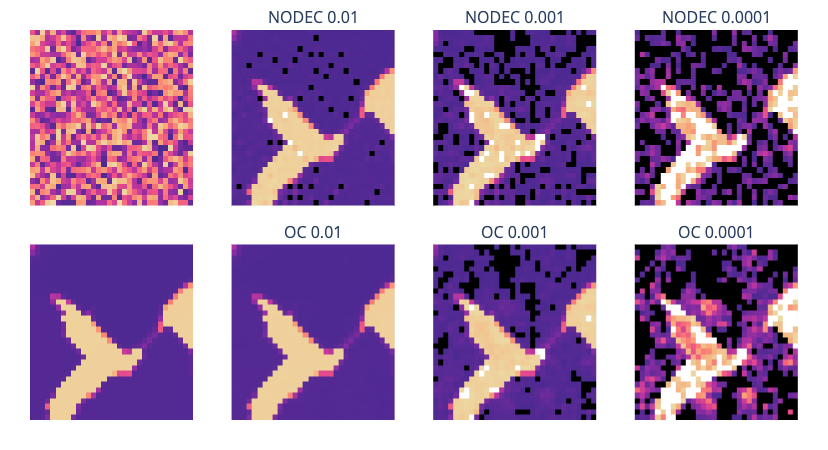

In [13]:

fig.add_trace(fig_x0.data[0], 1, 1)

fig.add_trace(fig_xstar.data[0], 2, 1)

fig.add_trace(all_figs['nodec_5000'].data[0], 1, 2)


fig.add_trace(all_figs['nodec_500'].data[0], 1, 3)


fig.add_trace(all_figs['nodec_50'].data[0], 1, 4)

fig.add_trace(all_figs['oc_5000'].data[0], 2, 2)


fig.add_trace(all_figs['oc_500'].data[0], 2, 3)


fig.add_trace(all_figs['oc_50'].data[0], 2, 4)


fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)
fig.layout.margin = dict(t=30,b=30,l=30,r=30)
fig.update_traces(showscale=False)
fig